# Testing posterior estimators in the LFI context

In [1]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CP2LFI.posterior_models import normflow_posterior

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg

## Using a visible example:

Simulating and testing for weinberg:

In [2]:
simulator = weinberg.Simulator(default_beam_energy=40.0)
prior = weinberg.Prior()

Setting $n = 100$ and $B^{'} = 20000$ for posterior modeling:

In [3]:
100*100

10000

In [4]:
B_model = 20000
n = 100
torch.manual_seed(45)
torch.cuda.manual_seed(45)
# simulating thetas
thetas = prior.sample((B_model, ))
repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

# simulating X's
X_sample = simulator(repeated_thetas)

In [5]:
thetas.dtype

torch.float32

In [6]:
50*100

5000

In [7]:
thetas.ndim

1

In [8]:
X_dim = X_sample.shape[1]
X_net = X_sample.reshape(B_model, n * X_dim)

In [9]:
X_net.shape

torch.Size([20000, 100])

Fitting normalizing flow model:

In [10]:
# reshaping thetas
thetas = thetas.reshape(-1, 1)
nflow_post = normflow_posterior(
    latent_size = thetas.shape[1],
    sample_size = X_net.shape[1], 
    n_flows = 8, 
    hidden_units = 128, 
    hidden_layers = 2,
    enable_cuda = True,
    )

nflow_post.fit(X_net.numpy(), thetas.numpy(), patience = 100, n_epochs = 2000, batch_size = 250)

Fitting normalizing flows posterior estimator:  27%|██▋       | 537/2000 [05:12<14:12,  1.72it/s]

Early stopping at epoch 537
a


normflow_posterior(latent_size=1, sample_size=100)

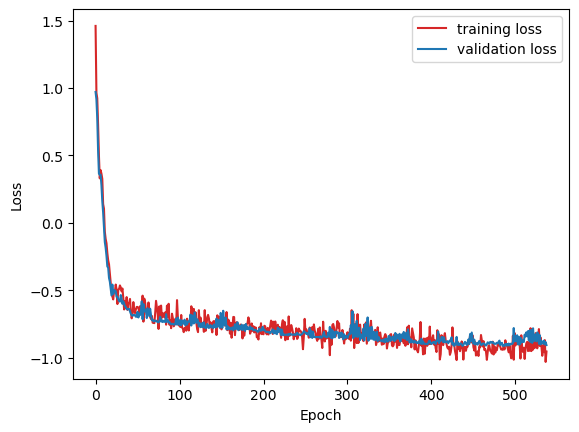

In [11]:
nflow_post.plot_history()

Simulating sample to fit confidence regions estimators:

In [12]:
# simulating to fit estimated confidence regions
B_rand = 10000
n = 100

torch.manual_seed(125)
# sampling from theta
thetas_new = prior.sample((B_rand, ))
repeated_thetas = thetas_new.repeat_interleave(repeats = n, dim = 0)
X_conf = simulator(repeated_thetas)
X_dim = X_conf.shape[1]
X_net = X_conf.reshape(B_rand, n * X_dim)

Computing all scores dataset:

In [13]:
# reshaping array
thetas_new = thetas_new.reshape(-1, 1)

# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()
sample_waldo = waldo_score.compute(thetas_new.numpy(), X = X_net.numpy(), N = 1000)

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()
sample_bff = bff_score.compute(thetas_new.numpy(), X = X_net.numpy())

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()
sample_e_value = e_value_score.compute(thetas_new.numpy(), X = X_net.numpy(), N = 1000)

Computing waldo statistics using posterior model: 100%|██████████| 10000/10000 [05:20<00:00, 31.16it/s]
Computing e-value statistics using posterior model: 100%|██████████| 10000/10000 [16:11<00:00, 10.29it/s]


Fitting a fixed TRUST++ to the problem:

In [14]:
alpha, min_samples_leaf, n_estimators, K = 0.05, 300, 200, 70

# fitting TRUST++ to waldo and visualizing
loforest_waldo = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_waldo.calibrate(
    thetas_new.numpy(), 
    sample_waldo, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to BF
loforest_bf = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_bf.calibrate(
    thetas_new.numpy(), 
    sample_bff, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

# fitting to e-value
loforest_e_value = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )

loforest_e_value.calibrate(
    thetas_new.numpy(), 
    sample_e_value, 
    min_samples_leaf=min_samples_leaf, 
    n_estimators= n_estimators,
    K = K,
)

Computing confidence regions:

In [15]:
res_thetas = np.linspace(0.5001, 1.4999, 500).reshape(-1, 1)
# waldo cutoffs
waldo_cutoffs = loforest_waldo.compute_cutoffs(res_thetas)

# bayes factor cutoffs
bf_cutoffs = loforest_bf.compute_cutoffs(res_thetas)

# e_value cutoffs
e_value_cutoffs = loforest_e_value.compute_cutoffs(res_thetas)

Testing $X$ generated fixing $\theta = 1$:

In [16]:
# observed data with n = 5
torch.manual_seed(45)
theta = 1
X = simulator(np.repeat(theta, n))
X = X.squeeze().numpy()
X

array([-0.626782  , -0.9645604 , -0.8492604 , -0.7845533 , -0.4647102 ,
        0.82478803,  0.40238652, -0.03555584,  0.7314466 , -0.8931852 ,
        0.25672194, -0.9099928 , -0.8673893 , -0.8727614 , -0.49099585,
       -0.94300294, -0.6536698 , -0.97203904, -0.7245273 ,  0.9398112 ,
       -0.9725596 , -0.9091353 ,  0.96807337, -0.90408427,  0.14007896,
       -0.9803669 ,  0.15024455, -0.08214103, -0.4773932 ,  0.40563056,
       -0.43424606, -0.18239084, -0.4429748 , -0.9666729 , -0.52769667,
       -0.5052501 , -0.75434965, -0.6068886 , -0.11058714, -0.9563648 ,
        0.31792665,  0.04794921,  0.09949391, -0.9695295 , -0.9337879 ,
       -0.44594112, -0.77416146,  0.06328679, -0.7976449 ,  0.5979556 ,
       -0.02093001, -0.1546611 ,  0.22458842, -0.88572556, -0.47567332,
       -0.98852706,  0.7609303 , -0.80968153, -0.7669231 , -0.4831047 ,
       -0.29902202, -0.9210766 ,  0.23103055, -0.74473894, -0.67499864,
       -0.1038565 , -0.8616395 , -0.8992866 , -0.9033704 , -0.08

Analysing distribution:

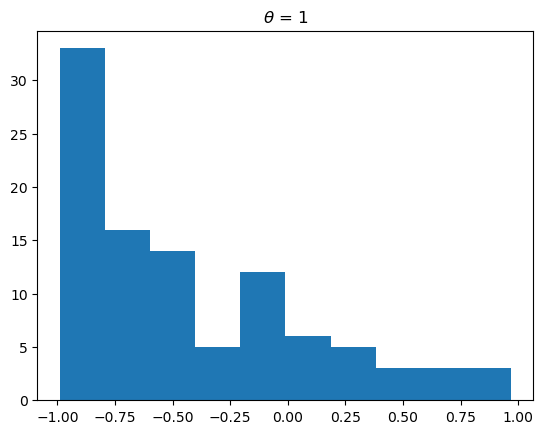

In [17]:
plt.hist(X)
plt.title(r"$\theta$ = 1")
plt.show()

Comparing to $\theta = 0.55$:

In [18]:
torch.manual_seed(45)
theta = 0.55
X_alt = simulator(np.repeat(theta, n))
X_alt = X_alt.squeeze().numpy()

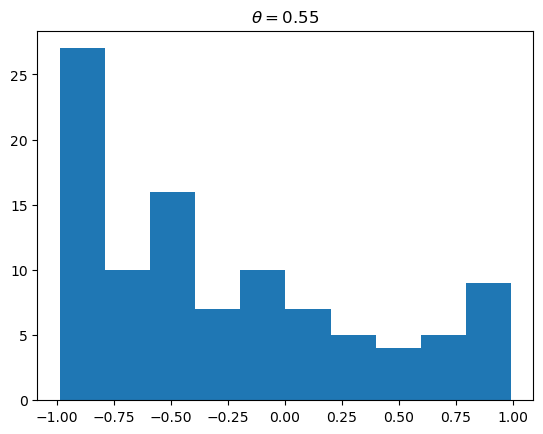

In [19]:
plt.hist(X_alt)
plt.title(r"$\theta = 0.55$")
plt.show()

In [20]:
thetas_nflow = nflow_post.sample(X, num_samples = 10000)

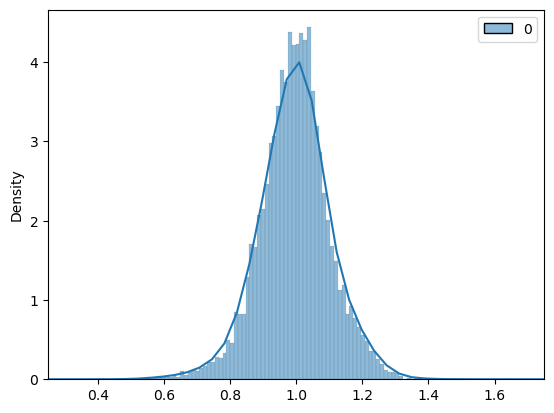

In [21]:
# posterior probability for all theta
import seaborn as sns
sns.histplot(thetas_nflow, kde = True, stat = "density")
plt.xlim(0.25, 1.75)
plt.show()

In [22]:
waldo_conf = waldo_score.predict(res_thetas, X = X, cutoffs = waldo_cutoffs)
bff_conf = bff_score.predict(res_thetas, X = X, cutoffs = bf_cutoffs)
e_value_conf = e_value_score.predict(res_thetas, X = X, cutoffs = e_value_cutoffs)

Computing waldo statistics using posterior model: 100%|██████████| 500/500 [00:15<00:00, 31.47it/s]
Computing e-value statistics using posterior model: 100%|██████████| 500/500 [00:48<00:00, 10.40it/s]


In [23]:
waldo_conf

array([0.6944499 , 0.69845711, 0.70246433, 0.73051483, 0.73251844,
       0.73452204, 0.73652565, 0.74053287, 0.74253647, 0.74454008,
       0.74654369, 0.7505509 , 0.75255451, 0.75656172, 0.76457615,
       0.76657976, 0.77058697, 0.77259058, 0.7765978 , 0.7786014 ,
       0.78060501, 0.78260862, 0.78461222, 0.78661583, 0.79262665,
       0.79463026, 0.79863747, 0.80064108, 0.80264469, 0.8046483 ,
       0.80865551, 0.81065912, 0.81266273, 0.81466633, 0.81666994,
       0.81867355, 0.82268076, 0.82468437, 0.82668798, 0.83069519,
       0.8326988 , 0.8347024 , 0.83670601, 0.83870962, 0.84271683,
       0.84472044, 0.84672405, 0.84872766, 0.85073126, 0.85273487,
       0.85473848, 0.85674208, 0.85874569, 0.8607493 , 0.86275291,
       0.86475651, 0.86676012, 0.86876373, 0.87076733, 0.87277094,
       0.87477455, 0.87677816, 0.87878176, 0.88278898, 0.88479259,
       0.88679619, 0.8887998 , 0.89080341, 0.89280701, 0.89481062,
       0.89681423, 0.89881784, 0.90082144, 0.90282505, 0.90482

In [24]:
e_value_conf

array([0.77058697, 0.77459419, 0.7765978 , 0.7786014 , 0.78060501,
       0.78260862, 0.78461222, 0.78661583, 0.78861944, 0.79062305,
       0.79262665, 0.79463026, 0.79663387, 0.79863747, 0.80064108,
       0.80264469, 0.8046483 , 0.8066519 , 0.80865551, 0.81065912,
       0.81266273, 0.81466633, 0.81666994, 0.81867355, 0.82067715,
       0.82268076, 0.82468437, 0.82668798, 0.82869158, 0.83069519,
       0.8326988 , 0.8347024 , 0.83670601, 0.83870962, 0.84071323,
       0.84271683, 0.84472044, 0.84672405, 0.84872766, 0.85073126,
       0.85273487, 0.85473848, 0.85674208, 0.85874569, 0.8607493 ,
       0.86275291, 0.86475651, 0.86676012, 0.86876373, 0.87076733,
       0.87277094, 0.87477455, 0.87677816, 0.87878176, 0.88078537,
       0.88278898, 0.88479259, 0.88679619, 0.8887998 , 0.89080341,
       0.89280701, 0.89481062, 0.89681423, 0.89881784, 0.90082144,
       0.90282505, 0.90482866, 0.90683226, 0.90883587, 0.91083948,
       0.91284309, 0.91484669, 0.9168503 , 0.91885391, 0.92085

In [25]:
bff_conf

array([0.78461222, 0.78661583, 0.78861944, 0.79062305, 0.79262665,
       0.79463026, 0.79663387, 0.79863747, 0.80064108, 0.80264469,
       0.8046483 , 0.8066519 , 0.80865551, 0.81065912, 0.81266273,
       0.81466633, 0.81666994, 0.81867355, 0.82067715, 0.82268076,
       0.82468437, 0.82668798, 0.82869158, 0.83069519, 0.8326988 ,
       0.8347024 , 0.83670601, 0.83870962, 0.84071323, 0.84271683,
       0.84472044, 0.84672405, 0.84872766, 0.85073126, 0.85273487,
       0.85473848, 0.85674208, 0.85874569, 0.8607493 , 0.86275291,
       0.86475651, 0.86676012, 0.86876373, 0.87076733, 0.87277094,
       0.87477455, 0.87677816, 0.87878176, 0.88078537, 0.88278898,
       0.88479259, 0.88679619, 0.8887998 , 0.89080341, 0.89280701,
       0.89481062, 0.89681423, 0.89881784, 0.90082144, 0.90282505,
       0.90482866, 0.90683226, 0.90883587, 0.91083948, 0.91284309,
       0.91484669, 0.9168503 , 0.91885391, 0.92085752, 0.92286112,
       0.92486473, 0.92686834, 0.92887194, 0.93087555, 0.93287

Plotting all confidence intervals:

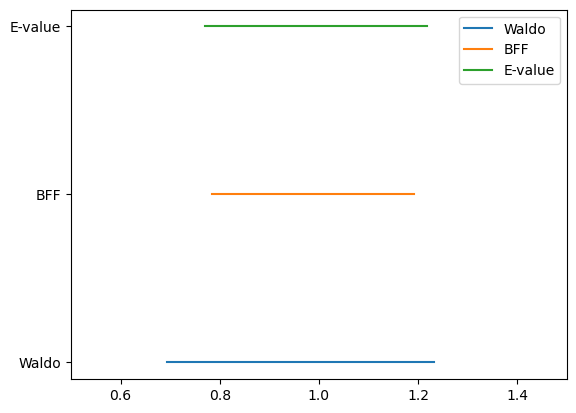

In [26]:
x_1 = np.repeat(np.array(["Waldo"]),waldo_conf.shape[0])
x_2 = np.repeat(np.array(["BFF"]),bff_conf.shape[0])
x_3 = np.repeat(np.array(["E-value"]),e_value_conf.shape[0])
plt.errorbar(waldo_conf, x_1, label = "Waldo")
plt.errorbar(bff_conf, x_2, label = "BFF")
plt.errorbar(e_value_conf, x_3, label = "E-value")
plt.xlim(0.5, 1.5)
plt.legend()
plt.show()